In [97]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from datetime import datetime
import matplotlib.animation as animation
from copy import deepcopy as copy
from src import convert

### Initialization

In [98]:
start_time = datetime.now()

# Data extracted from the horizon results
DT = 600 # in seconds
T = 2500

### Body class

In [99]:
class Body():

    all = []

    def __init__(self, name, pos, vel, acc, gm):
        self.name = name
        self.pos = pos
        self.initial_pos = pos
        self.vel = vel
        self.initial_vel = vel
        self.acc = acc
        self.initial_acc = acc
        self.gm = gm
        self.pos_evol = np.zeros((T,3))
        self.pos_evol[0] = self.pos
        self.vel_evol = np.zeros((T,3))
        self.vel_evol[0] = self.vel
        self.acc_evol = np.zeros((T,3))
        self.acc_evol[0] = self.acc
        Body.all.append(self)

### Body definition

In [100]:
mimas = Body(
    name = 'Mimas',
    pos  = np.array([-1.813557294137345E+05, 3.492995866271013E+04, 5.054192147215439E+03]),
    vel  = np.array([-2.445920348718876E+00, 1.416736794928916E+01, 1.873213454946043E-02]),
    acc  = np.array([0,0,0]),
    gm   = 2.503489)

thetys = Body(
    name = 'Thetys',
    pos  = np.array([-1.889929479196472E+05, -2.260662471700913E+05, -7.020174976279632E+02]),
    vel  = np.array([8.706811449016753E+00, -7.280896606319645E+00, -2.143307520131600E-01]),
    acc  = np.array([0,0,0]),
    gm   = 41.21)

titan = Body(
    name = 'Titan',
    pos  = np.array([2.956179324256932E+05, 1.212611254175863E+06, -6.683800852915738E+02]),
    vel  = np.array([-5.322398770209340E+00, 1.190373084298060E+00, -3.847254100240810E-02]),
    acc  = np.array([0,0,0]),
    gm   = 8978.14)

saturn = Body(
    name = 'Saturn',
    pos  = np.array([0,0,0]),
    vel  = np.array([0,0,0]),
    acc  = np.array([0,0,0]),
    gm   = 37931206.2)

# Initial acceleration
# for body in [mimas, thetys, titan]:
#     body.acc = body.compute_acceleration(saturn)

### Runge-Kutta integrator

In [101]:
# Acceleration function : f(t,y) -> (v,a)     with y = (p,v)
def acceleration_rk(t, y, body = None, perturbated=False) -> np.array:
    pos = y[:3]
    vel = y[3:]

    gm = body.gm if body is not None else 0

    r = pos
    d = np.sqrt(np.sum(r**2))
    acc = - r * (saturn.gm + gm) / (d**3)

    if perturbated:
        for other_body in Body.all:
            if body is other_body or other_body is saturn:
                continue
            r = body.pos_evol[int(t/DT)] - pos
            d = np.sqrt(np.sum(r**2))
            acc = - r * body.gm / (d**3)

    return np.concatenate((vel, acc))

# Runge kutta 4th order : rk4(t,dt,y,evaluate) -> y     with y = (p,v)
def rk4(t,dt,y,evaluate, body = None, perturbated=False) -> np.array:

    k1 = evaluate(t, y, body=body, perturbated=perturbated)
    k2 = evaluate(t + 0.5*dt, y + 0.5*k1*dt, body=body, perturbated=perturbated)
    k3 = evaluate(t + 0.5*dt, y + 0.5*k2*dt, body=body, perturbated=perturbated)
    k4 = evaluate(t + dt, y + dt*k3, body=body, perturbated=perturbated)
    
    y_new = y + (1./6.)*(k1+ 2.*k2 + 2.*k3 + k4) * dt

    return y_new

In [102]:
def acceleration_lf(body, perturbated=False):

    acc = np.array([0,0,0])
    r = body.pos
    d = np.sqrt(np.sum(r**2))
    acc = acc - r * (saturn.gm + body.gm) / (d**3)

    if perturbated:
        for other_body in Body.all:
            if body is other_body or saturn is other_body:
                continue
            r = body.pos - other_body.pos
            d = np.sqrt(np.sum(r**2))
            acc = acc - r * other_body.gm / (d**3)

    return acc

### Time evolution

In [103]:
def evolve(method="rk", perturbated=False):

    for body in Body.all:
        body.pos = body.initial_pos
        body.vel = body.initial_vel
        body.acc = body.initial_acc

    # Runge Kutta method
    if method == "rk":
        for t in range(1,T):    
            for body in [mimas, thetys, titan]:

                y = np.concatenate((body.pos, body.vel))
                y = rk4(t*DT, DT, y, acceleration_rk, body=body, perturbated=perturbated)

                body.pos = y[:3]
                body.vel = y[3:]

                body.pos_evol[t] = body.pos
                body.vel_evol[t] = body.vel

    # Leap Frog method
    elif method == "lf":
        for t in range(1,T):
            for body in [mimas, thetys, titan]:

                body.pos = body.pos + body.vel * DT + body.acc/2 * DT**2
                body.vel =            body.vel      + body.acc/2 * DT
                body.acc = acceleration_lf(body)
                if body is titan:
                    body.acc *= 5.5
                body.vel =            body.vel      + body.acc/2 * DT

                body.pos_evol[t] = body.pos
                body.vel_evol[t] = body.vel

evolve(method="lf")

### Plot position evolution

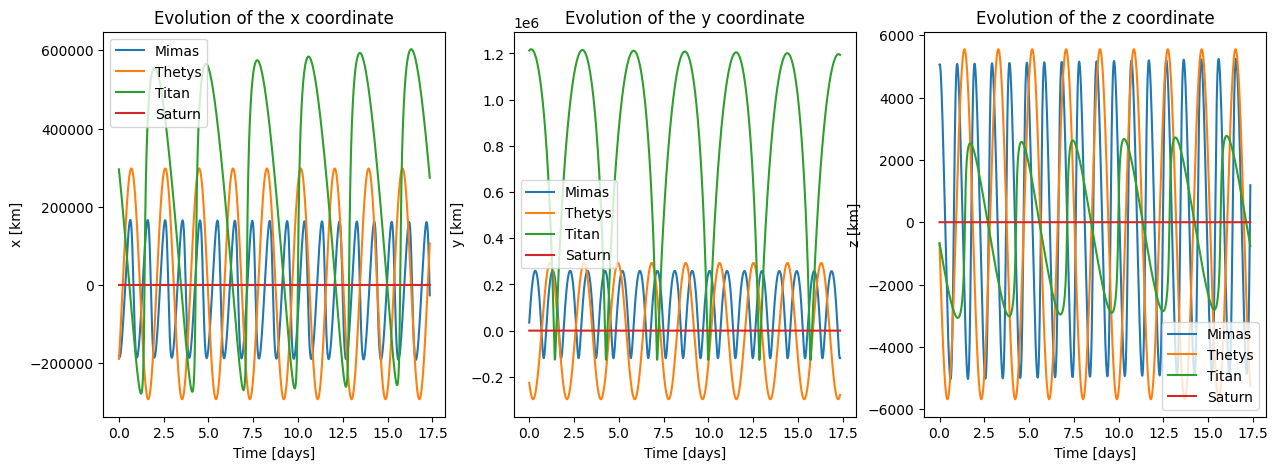

In [104]:
fig = plt.figure(figsize=(15,5))

# Evolution of the x coordinate
plt.subplot(131)
plt.title('Evolution of the x coordinate')
for body in Body.all:
    plt.plot(np.arange(T)*DT/86400.0, body.pos_evol[:,0], label=body.name)
plt.xlabel('Time [days]')
plt.ylabel('x [km]')
plt.legend()

# Evolution of the y coordinate
plt.subplot(132)
plt.title('Evolution of the y coordinate')
for body in Body.all:
    plt.plot(np.arange(T)*DT/86400.0, body.pos_evol[:,1], label=body.name)
plt.xlabel('Time [days]')
plt.ylabel('y [km]')
plt.legend()

# Evolution of the z coordinate
plt.subplot(133)
plt.title('Evolution of the z coordinate')
for body in Body.all:
    plt.plot(np.arange(T)*DT/86400.0, body.pos_evol[:,2], label=body.name)
plt.xlabel('Time [days]')
plt.ylabel('z [km]')
plt.legend()

### 3D representation of orbits

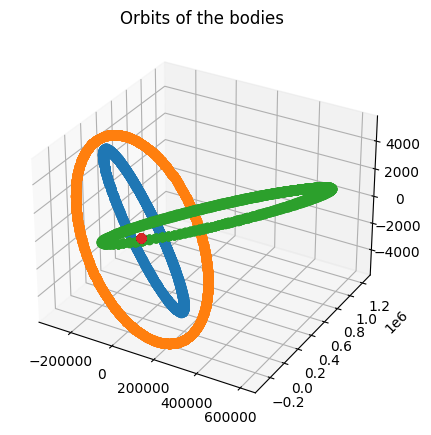

In [105]:
fig = plt.figure(figsize=(5,5))

ax = plt.subplot(111, projection='3d')
ax.set_title('Orbits of the bodies')
for body in Body.all:
    ax.plot(body.pos_evol[:,0], body.pos_evol[:,1], body.pos_evol[:,2], marker='o', label=body.name)

### Plot velocity evolution

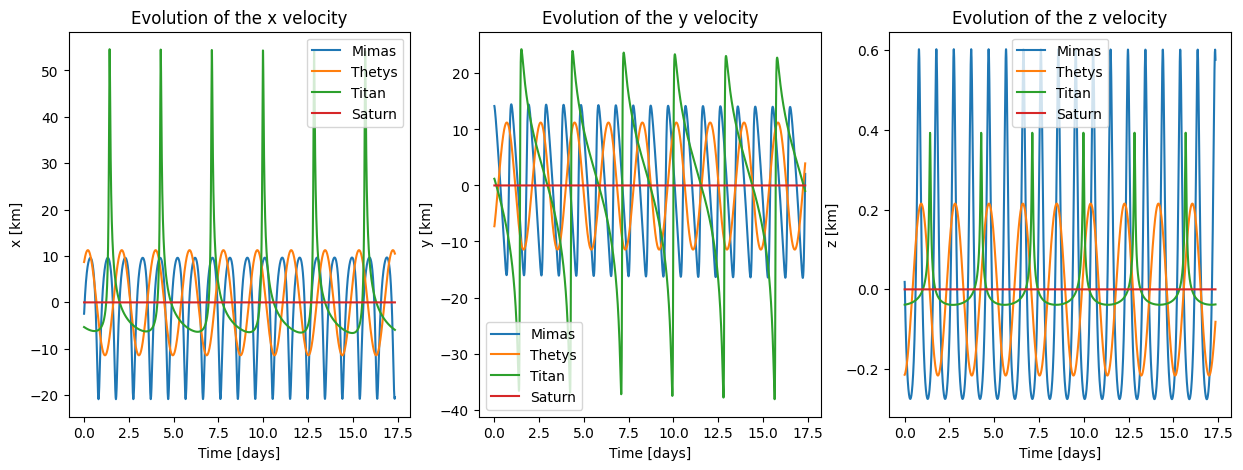

In [106]:
fig = plt.figure(figsize=(15,5))

# Evolution of the x velocity
plt.subplot(131)
plt.title('Evolution of the x velocity')
for body in Body.all:
    plt.plot(np.arange(T)*DT/86400.0, body.vel_evol[:,0], label=body.name)
plt.xlabel('Time [days]')
plt.ylabel('x [km]')
plt.legend()

# Evolution of the y velocity
plt.subplot(132)
plt.title('Evolution of the y velocity')
for body in Body.all:
    plt.plot(np.arange(T)*DT/86400.0, body.vel_evol[:,1], label=body.name)
plt.xlabel('Time [days]')
plt.ylabel('y [km]')
plt.legend()

# Evolution of the z velocity
plt.subplot(133)
plt.title('Evolution of the z velocity')
for body in Body.all:
    plt.plot(np.arange(T)*DT/86400.0, body.vel_evol[:,2], label=body.name)
plt.xlabel('Time [days]')
plt.ylabel('z [km]')
plt.legend()

### Convert to orbital elements

In [107]:
for body in Body.all:
    body.orb_evol = np.zeros((T,6))
    for t in range(0,T):
        body.orb_evol[t] = convert.cartesian_to_orbital(body.pos_evol[t], body.vel_evol[t], saturn.gm + body.gm)
        if body is thetys and t < 10:
            print(f"At t={t}: {[round(i,3) for i in body.orb_evol[t]]}")

At t=0: [294975.024, -0.001, -0.001, 0.007, 0.006, -2.267]
At t=1: [295015.657, -0.01, 0.007, 0.007, 0.006, -2.267]
At t=2: [295015.678, -0.01, 0.007, 0.007, 0.006, -2.244]
At t=3: [295015.7, -0.01, 0.007, 0.007, 0.006, -2.221]
At t=4: [295015.721, -0.01, 0.007, 0.007, 0.006, -2.198]
At t=5: [295015.742, -0.01, 0.007, 0.007, 0.006, -2.175]
At t=6: [295015.764, -0.01, 0.007, 0.007, 0.006, -2.152]
At t=7: [295015.785, -0.01, 0.007, 0.007, 0.006, -2.129]
At t=8: [295015.806, -0.01, 0.007, 0.007, 0.006, -2.106]
At t=9: [295015.827, -0.01, 0.007, 0.007, 0.006, -2.083]


c:\Users\vince\Documents\Dev\CompuPhys\M2-Saturn-moons\src\convert.py:104: RuntimeWarning: invalid value encountered in sqrt
  psi = 1/(1+np.sqrt(1-k*k-h*h))
c:\Users\vince\Documents\Dev\CompuPhys\M2-Saturn-moons\src\convert.py:81: RuntimeWarning: invalid value encountered in double_scalars
  cis2 = np.sqrt(0.5 * (1 + gz / gg))


When the system is not perturbated, we see that the orbital elements are conserved.

### Adding perturbations

In [108]:
evolve(method="rk", perturbated=True)

IndexError: index 2500 is out of bounds for axis 0 with size 2500

### Plot position evolution

In [ ]:
fig = plt.figure(figsize=(15,5))

# Evolution of the x coordinate
plt.subplot(131)
plt.title('Evolution of the x coordinate')
for body in Body.all:
    plt.plot(np.arange(T)*DT/86400.0, body.pos_evol[:,0], label=body.name)
plt.xlabel('Time [days]')
plt.ylabel('x [km]')
plt.legend()

# Evolution of the y coordinate
plt.subplot(132)
plt.title('Evolution of the y coordinate')
for body in Body.all:
    plt.plot(np.arange(T)*DT/86400.0, body.pos_evol[:,1], label=body.name)
plt.xlabel('Time [days]')
plt.ylabel('y [km]')
plt.legend()

# Evolution of the z coordinate
plt.subplot(133)
plt.title('Evolution of the z coordinate')
for body in Body.all:
    plt.plot(np.arange(T)*DT/86400.0, body.pos_evol[:,2], label=body.name)
plt.xlabel('Time [days]')
plt.ylabel('z [km]')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(5,5))

ax = plt.subplot(111, projection='3d')
ax.set_title('Orbits of the bodies')
for body in Body.all:
    ax.plot(body.pos_evol[:,0], body.pos_evol[:,1], body.pos_evol[:,2], marker='o', label=body.name)

### Orbital elements

In [ ]:
for body in Body.all:
    body.orb_evol = np.zeros((T,6))
    for t in range(0,T):
        body.orb_evol[t] = convert.cartesian_to_orbital(body.pos_evol[t], body.vel_evol[t], saturn.gm + body.gm)
        if body is thetys and t < 10:
            print(f"At t={t}: {[round(i,3) for i in body.orb_evol[t]]}")